### Import XML and transform to dataframe
##### Data Source: https://www.censtatd.gov.hk/hkstat/sub/sp150.jsp?productCode=X1130301

In [2]:
import xml.etree.ElementTree as eletree
import pandas as pd

In [3]:
tr1 = eletree.parse('DCP_Masterdata.xml').getroot()
masterdata = pd.DataFrame(None)
for i in range(0,len(tr1[0][0])):
    col_count = len(list(tr1[0][0][i]))
    d_row = {}
    for j in range(0,col_count):
        d_update = {tr1[0][0][i][j].tag : tr1[0][0][i][j].text}
        d_row.update(d_update)
    masterdata = masterdata.append(pd.DataFrame(d_row, index=[i]))

C:\Users\Miko\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [4]:
masterdata.head(3)

,AGE,AGE_PROP,CCYY,DCD,DCD_PROP,EAS,EDU,HHS,MARRIED,MDHI,...,SD_VALUE,SEX,SEX_PROP,STATUS,STAT_PRES,STAT_VALUE,STAT_VAR,TENURE,THEME,TYPEOA
0,NaN,NaN,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,f,Raw_1dp,2.8,ADHS,NaN,DCP,NaN
1,NaN,NaN,2016,1,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,f,Raw_1dp,2.7,ADHS,NaN,DCP,NaN
2,NaN,NaN,2016,10,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,f,Raw_1dp,2.9,ADHS,NaN,DCP,NaN


In [5]:
tr2 = eletree.parse('DCP_Metadata.xml').getroot()
metadata = [pd.DataFrame(None) for i in range(0,len(list(tr2[0])))]
for i in range(0,len(list(tr2[0]))):
    elem = tr2[0][i]
    row_count = len(list(tr2[0][i]))
    for j in range(0,row_count):
        col_count = len(list(tr2[0][i][j]))
        d_row = elem.attrib
        for k in range(0,col_count):
            d_update = {tr2[0][i][j][k].tag : tr2[0][i][j][k].text}
            d_row.update(d_update)
        metadata[i] = metadata[i].append(pd.DataFrame(d_row, index=[i]))

In [6]:
# print metadata table order and names
i = 0
for df in metadata:
    if 'name' in df.columns:
        print(i, " : ", df['name'].unique()[0])
    else:
        pass
    i+=1

0  :  Entity
1  :  Schema
2  :  Status
3  :  Reference Per Collect
4  :  Special Display
5  :  Statistics Multiplier
6  :  Statistics Precision
7  :  Statistics Type
8  :  Statistical Variable Presentation
9  :  Classification Variable
10  :  Classification Code
11  :  Suggested Classification Group
12  :  Parent-child Classification Group


### Subset Population Data from masterdata

In [7]:
# identify statistical variables for population
metadata[8].loc[metadata[8]['STAT_PRES_DESC_ENG'].str.contains('Population',case=False),['STAT_VAR','STAT_PRES_DESC_ENG','STAT_PRES_DESC_CHI','STAT_PRES']]

,STAT_VAR,STAT_PRES_DESC_ENG,STAT_PRES_DESC_CHI,STAT_PRES
8,MyP,Mid-year population,年中人口,Raw_K_1dp
8,NOP,Percentage of population,人口百分比,Prop_1dp
8,NOP,Population,人口數目,Raw_00


In [8]:
# subset masterdata to focus on population
population = masterdata[(masterdata['STAT_VAR']=='NOP')&(masterdata['STAT_PRES']=='Raw_00')].dropna(axis=1,how='all')
population['STAT_VALUE'] = population['STAT_VALUE'].astype(int)
population.head(3)

,AGE,CCYY,DCD,EAS,EDU,MARRIED,REF_PER_COLLECT,SD_VALUE,SEX,STATUS,STAT_PRES,STAT_VALUE,STAT_VAR,THEME
3534,55-64,2016,9,NaN,NaN,NaN,A,0,NaN,f,Raw_00,98600,NOP,DCP
3535,55-64,2016,9,NaN,NaN,NaN,A,0,F,f,Raw_00,50800,NOP,DCP
3536,55-64,2016,9,NaN,NaN,NaN,A,0,M,f,Raw_00,47800,NOP,DCP


In [9]:
# merge with metadata to get the categorial varialbe CLASS_PARENT_TF_CODE - indicate corresponding region of districts
class_cols = ['AGE', 'EAS', 'EDU', 'MARRIED', 'SEX']
pop_temp = population[(population[class_cols].isna().all(1))].merge(metadata[12][metadata[12]['CLASS_VAR']=='DCD'][['CLASS_CHILD_TF_CODE','CLASS_PARENT_TF_CODE']],
                                                                   how='left',
                                                                   left_on = 'DCD',
                                                                   right_on='CLASS_CHILD_TF_CODE')
pop_temp.head(3)

,AGE,CCYY,DCD,EAS,EDU,MARRIED,REF_PER_COLLECT,SD_VALUE,SEX,STATUS,STAT_PRES,STAT_VALUE,STAT_VAR,THEME,CLASS_CHILD_TF_CODE,CLASS_PARENT_TF_CODE
0,NaN,2016,9,NaN,NaN,NaN,A,0,NaN,f,Raw_00,643600,NOP,DCP,9,KLN
1,NaN,2016,8,NaN,NaN,NaN,A,0,NaN,f,Raw_00,421300,NOP,DCP,8,KLN
2,NaN,2016,7,NaN,NaN,NaN,A,0,NaN,f,Raw_00,413800,NOP,DCP,7,KLN


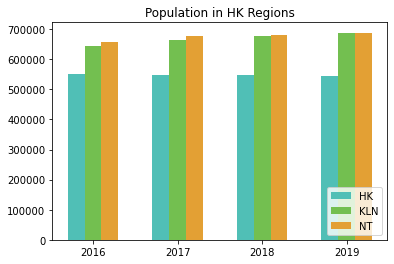

In [10]:
# Bar chart of HK population in 3 regions (HK, KLN, NT)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

f1, ax1 = plt.subplots()
color = {'HK':'#50bfb6', 'KLN':'#73bf50', 'NT':'#e3a034'}
i=0
for dcd in ['HK','KLN','NT']:
    y = pop_temp.loc[pop_temp['CLASS_PARENT_TF_CODE']==dcd,'STAT_VALUE'].astype(int)
    x = pop_temp.loc[pop_temp['CLASS_PARENT_TF_CODE']==dcd,'CCYY'].astype(int)
    ax1.bar(x+(i/5-0.2), y, label=dcd, width=0.2, color=color[dcd])
    i+=1
    
ax1.set_title('Population in HK Regions')
ax1.legend(loc='lower right')
#ax1.grid(b=True, which='major', axis='both')
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

### Compare Population & Household income among districts

In [11]:
# identify statistical variables for household income
metadata[8].loc[metadata[8]['STAT_PRES_DESC_ENG'].str.contains('income',case=False),['STAT_VAR','STAT_PRES_DESC_ENG','STAT_PRES_DESC_CHI','STAT_PRES']]

,STAT_VAR,STAT_PRES_DESC_ENG,STAT_PRES_DESC_CHI,STAT_PRES
8,MdnMDHI,Median monthly household income,住戶每月入息中位數,Raw_00
8,MdnMDHI_xei,Median monthly household income of economicall...,從事經濟活動的家庭住戶每月入息中位數,Raw_00


In [12]:
# subset masterdata to focus on household income
income = masterdata[(masterdata['STAT_VAR']=='MDNMDHI')&(masterdata['STAT_PRES']=='Raw_00')].dropna(axis=1,how='all')
income = income.merge(metadata[10].loc[metadata[10]['CLASS_VAR']=='DCD',['CLASS_CODE','CLASS_CODE_DESC_ENG','CLASS_CODE_DESC_CHI']], 
                      how='left',
                      left_on='DCD',
                      right_on='CLASS_CODE')
income.head(3)

,CCYY,DCD,REF_PER_COLLECT,SD_VALUE,STATUS,STAT_PRES,STAT_VALUE,STAT_VAR,THEME,CLASS_CODE,CLASS_CODE_DESC_ENG,CLASS_CODE_DESC_CHI
0,2016,NaN,A,0,f,Raw_00,25200,MDNMDHI,DCP,NaN,NaN,NaN
1,2016,1,A,0,f,Raw_00,39500,MDNMDHI,DCP,1,Central & Western,中西區
2,2016,10,A,0,f,Raw_00,21200,MDNMDHI,DCP,10,Kwai Tsing,葵青


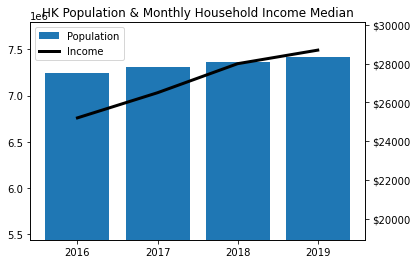

In [13]:
# Year Trend of HK Monthly Household Income Median
fig, ax1 = plt.subplots()

y1 = pop_temp.loc[pop_temp['DCD'].isna(),'STAT_VALUE'].astype(int)
x = pop_temp.loc[pop_temp['DCD'].isna(),'CCYY'].astype(int)
p1 = ax1.bar(x, y1, label='Population')

y2 = income.loc[income['DCD'].isna(),'STAT_VALUE'].astype(int)
x2 = income.loc[income['DCD'].isna(),'CCYY'].astype(int)
ax2 = ax1.twinx()
p2 = ax2.plot(x, y2, color='black', linewidth=3, label='Income')

ax1.set_title('HK Population & Monthly Household Income Median')
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax1.set_ylim(bottom=min(y1)*0.75, top=max(y1)*1.05)
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%1.0f'))
ax2.set_ylim(bottom=min(y2)*0.75, top=max(y2)*1.05)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
plt.legend(h1+h2,l1+l2)
plt.show()

In [14]:
# subset masterdata to focus on household income breakdown by district
pop_income = pop_temp.merge(income[['CCYY', 'DCD', 'STAT_VALUE','CLASS_CODE_DESC_ENG']].rename(columns={'STAT_VALUE':'MDNMDHI'}),
                            how='left',
                            on=['CCYY', 'DCD'])
pop_income[['CCYY','STAT_VALUE','MDNMDHI']] = pop_income[['CCYY','STAT_VALUE','MDNMDHI']].astype(int)
pop_income.head(3)

,AGE,CCYY,DCD,EAS,EDU,MARRIED,REF_PER_COLLECT,SD_VALUE,SEX,STATUS,STAT_PRES,STAT_VALUE,STAT_VAR,THEME,CLASS_CHILD_TF_CODE,CLASS_PARENT_TF_CODE,MDNMDHI,CLASS_CODE_DESC_ENG
0,NaN,2016,9,NaN,NaN,NaN,A,0,NaN,f,Raw_00,643600,NOP,DCP,9,KLN,20800,Kwun Tong
1,NaN,2016,8,NaN,NaN,NaN,A,0,NaN,f,Raw_00,421300,NOP,DCP,8,KLN,22000,Wong Tai Sin
2,NaN,2016,7,NaN,NaN,NaN,A,0,NaN,f,Raw_00,413800,NOP,DCP,7,KLN,26900,Kowloon City


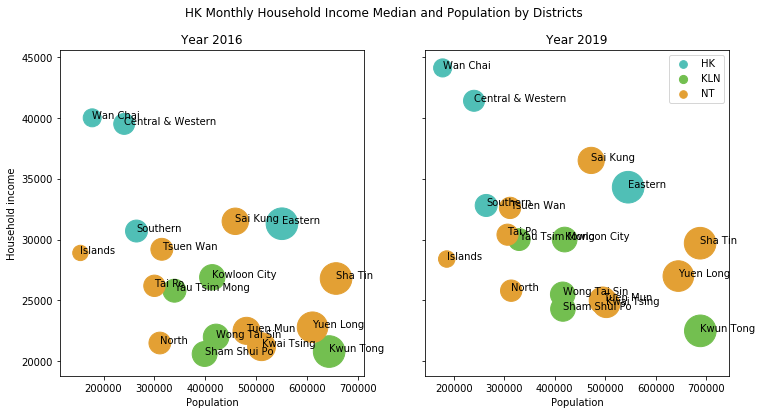

In [14]:
color = {'HK':'#50bfb6', 'KLN':'#73bf50', 'NT':'#e3a034'}
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,6))
for dcd in ['HK','KLN','NT']:
    # subplot1 for year 2016
    x1 = pop_income[(pop_income['CCYY']==2016)&(pop_income['CLASS_PARENT_TF_CODE']==dcd)]['STAT_VALUE']
    y1 = pop_income[(pop_income['CCYY']==2016)&(pop_income['CLASS_PARENT_TF_CODE']==dcd)]['MDNMDHI']
    s1 = x1*1000/(max(x1))
    n1 = pop_income[(pop_income['CCYY']==2016)&(pop_income['CLASS_PARENT_TF_CODE']==dcd)]['CLASS_CODE_DESC_ENG']
    ax1.scatter(x=x1,y=y1,s=s1,c=color[dcd],label=dcd)
    ax1.set_title('Year 2016')
    ax1.set_ylabel('Household income')
    ax1.set_xlabel('Population')
    for xi,yi,ni in zip(x1,y1,n1):
        ax1.annotate(ni,xy=(xi,yi))
    # subplot2 for year 2019
    x2 = pop_income[(pop_income['CCYY']==2019)&(pop_income['CLASS_PARENT_TF_CODE']==dcd)]['STAT_VALUE']
    y2 = pop_income[(pop_income['CCYY']==2019)&(pop_income['CLASS_PARENT_TF_CODE']==dcd)]['MDNMDHI']
    s2 = x2*1000/(max(x2))
    n2 = pop_income[(pop_income['CCYY']==2019)&(pop_income['CLASS_PARENT_TF_CODE']==dcd)]['CLASS_CODE_DESC_ENG']
    ax2.scatter(x=x2,y=y2,s=s2,c=color[dcd],label=dcd)
    ax2.set_title('Year 2019')
    ax2.set_xlabel('Population')
    for xi,yi,ni in zip(x2,y2,n2):
        ax2.annotate(ni,xy=(xi,yi))

ax2.legend(loc='upper right', markerscale=0.3)
fig.suptitle('HK Monthly Household Income Median and Population by Districts')
plt.show()

### Plot above Data on Map
##### GeoJSON Source: https://data.gov.hk/en-data/dataset/hk-had-json1-hong-kong-administrative-boundaries

In [15]:
# load geojson data
import json
import urllib.request as re

hkgeo_re = re.urlopen('https://www.had.gov.hk/psi/hong-kong-administrative-boundaries/hksar_18_district_boundary.json')
hkgeojson = json.loads(hkgeo_re.read())

In [18]:
import geopandas as gpd
from datetime import datetime as dt

hkgdf = gpd.GeoDataFrame.from_features(hkgeojson["features"])
hkgdf = hkgdf.merge(pop_income.loc[pop_income['CCYY']==2019,['CLASS_CODE_DESC_ENG','CLASS_PARENT_TF_CODE','CCYY','DCD','STAT_VALUE','STAT_VAR','MDNMDHI']], 
                    how='left', left_on='District', right_on='CLASS_CODE_DESC_ENG')

In [19]:
import pyproj
pyproj.Proj("+init=epsg:4326")

C:\Users\Miko\Anaconda3\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


Proj('+proj=longlat +datum=WGS84 +no_defs', preserve_units=True)

In [20]:
# transform combined data of geojson and income for folium to plot
hkgdf_folium = hkgdf
hkgdf_folium.crs = {'init':'epsg:4326'}
hkgdf_folium = hkgdf_folium.to_crs(epsg='4326')
hkgdf_folium.head(3)

C:\Users\Miko\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,geometry,地區號碼,District,地區,Administrative District Boundary of Hong Kong,CLASS_CODE_DESC_ENG,CLASS_PARENT_TF_CODE,CCYY,DCD,STAT_VALUE,STAT_VAR,MDNMDHI
0,"POLYGON ((114.14951 22.29748, 114.10987 22.297...",A,Central & Western,中西區,Administrative District Boundary of Hong Kong,Central & Western,HK,2019,1,240500,NOP,41400
1,"POLYGON ((114.19771 22.25790, 114.19778 22.258...",B,Wan Chai,灣仔,Administrative District Boundary of Hong Kong,Wan Chai,HK,2019,2,178400,NOP,44100
2,"POLYGON ((114.21939 22.29568, 114.21087 22.300...",C,Eastern,東區,Administrative District Boundary of Hong Kong,Eastern,HK,2019,3,545600,NOP,34300


In [33]:
import json
import folium
import folium.plugins
import branca
import branca.colormap as cm

color = {'HK':'#50bfb6', 'KLN':'#73bf50', 'NT':'#e3a034'}
def style3Region(feature):
    district = feature['properties']['CLASS_PARENT_TF_CODE']
    trans_level = feature['properties']['STAT_VALUE']/hkgdf_folium['STAT_VALUE'].max()
    return {'color':color[district],
            'fillOpacity':trans_level,
            'weight':1,
            'fillColor':color[district]
           }

def styleIncome(feature):
    color_level = feature['properties']['MDNMDHI']
    return {'color':'grey',
            'fillOpacity':0.3,
            'weight':1,
            'fillColor':color2(color_level)
           }

# plot 2 folium maps
m = folium.plugins.DualMap(location=(22.3041, 114.15112),
                           tiles='cartodbpositron',
                           zoom_start=10)

l1 = folium.Choropleth(geo_data=json.loads(hkgdf_folium.to_json()),
                       data=hkgdf_folium,
                       name='Income',
                       columns=['District', 'MDNMDHI'],
                       key_on='feature.properties.District',
                       fill_color='RdBu',
                       fill_opacity=0.7,
                       legend_name='Monthly household income median',
                       show=False)

folium.features.GeoJsonTooltip(fields=['District', 'MDNMDHI'],aliases=['District', '2019 Income']).add_to(l1.geojson)
l1.add_to(m.m1)

l2 = folium.GeoJson(hkgdf_folium[['geometry','District','CLASS_PARENT_TF_CODE','STAT_VALUE']],
                    name='Population',
                    control=True,
                    style_function=style3Region,
                    tooltip=folium.features.GeoJsonTooltip(fields=['District', 'STAT_VALUE'],
                                                           aliases=['District', '2019 Population']))
l2.add_to(m.m2)
cm2 = cm.StepColormap(colors=color.values())
cm2.caption = 'Districts'
m.m2.add_child(cm2)
m